![image.png](image.png)

In [ ]:
# !virtualenv venv --python=python3
# !source venv/bin/activate
# !pip install numpy pandas
# Se necessário instalar o jupyter dentro do ambiente virtual:
# !pip install jupyter

# Uma análise sobre a maior comunidade de Board Games do mundo (BoardGameGeek)
### Por Rômulo Filho 

Como muito bem exemplificou o  **SP TV** da Rede Globo, nos últimos anos os jogos de tabuleiro tem se diversificado tanto em variedade de temas quanto em complexidade de sistemas. 

Dos tradicionais **Jogo da Vida** e **Banco Imobiliário**, passando por já clássicos como **Catan** e **Carcassone**, até chegar a jogos extremamente complexos com partidas que duram várias horas. FALAR NOMES DE JOGOS COMPELXOS

Com um universo de possibilidades que cresce mais a cada dia, os "Boardgamers" se organizaram em comunidades tanto locais ao redor de luderias quanto online. No Brasil, a mais famosa é a Ludopedia, que segue o formato do BoardGameGeek (BGG). Este último é a maior rede social de jogos de tabuleiro do mundo.

Dessa forma, busco com este trabalho analisar um conjunto de dados do BGG disponível no [Kaggle](https://www.kaggle.com/gabrio/board-games-dataset) e responder as seguintes perguntas:
- Quais os jogos mais bem avaliados?
- Quem são os melhores Game Designers?
- O que define um bom jogo de tabuleiro?
- Qual a influência da dificuldade na nota?
- A duração de uma partida influencia na nota?
- Existe uma quantidade ideal de jogadores que influencie na nota?


In [ ]:
import sys
import sqlite3

import seaborn as sn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Configurações de print para melhor estudo dos dados
# np.set_printoptions(threshold=np.inf)
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)

In [ ]:
db_sql = sqlite3.connect('database.sqlite')

df = pd.read_sql_query("SELECT * FROM BoardGames", db_sql)
print(df.head())
print(df.tail())
print(df.shape)
db_sql.close()

In [ ]:
df

### Pré-processamento
Como o objeto de estudo desse trabalho são apenas **jogos de tabuleiro** vamos utilizar apenas as entradas do dataset cujo atributo _game.type_, que representa o tipo de jogo é igual a _boardgame_. Assim podemos remover as expansões e possíveis erros. 

In [468]:
print(df['game.type'].unique(), df.shape)
df = df[df['game.type']=='boardgame']
print(df['game.type'].unique(), df.shape)

['boardgame'] (22257, 33)
['boardgame'] (22257, 33)


Agora vamos excluir jogos que não possuem data de publicação, pois o Board Game Geek possbilita que jogos não lançados sejam adicionados no site. Normalmente estes são jogos criados de forma amadora, modificações não oficiais ou protótipos de outros jogos. Também vamos remover todos os jogos que possuem menos de 10 avaliações.

In [467]:
print(df.shape)
df.dropna(axis=0, subset=['details.yearpublished', ], inplace=True)
df = df[df['stats.usersrated'] >= 10]
print(df.shape)

(22257, 33)
(22257, 33)


O dataset disponibilizado inclui uma grande quantidade de dados que não serão úteis para responder as perguntas guia deste trabalho. Por isso iremos remover algumas colunas. Começamos removendo as colunas do tipo _polls_ que representam enquetes criadas nos fóruns do BGG, também removemos as colunas do tipo _family_ que representam a "família" do gênero do jogo e _subtype_ pois contém apenas informações secundárias e irrelevantes para este trabalho. 

In [ ]:
# Removendo colunas indesejadas
for col in df:
    if 'polls' in col or 'family' in col or 'subtype' in col:
        df.drop(col, axis=1, inplace=True)


df.drop('attributes.t.links.concat.2....', axis=1, inplace=True)
df.drop('details.description', axis=1, inplace=True)
df.drop('details.thumbnail', axis=1, inplace=True)
df.drop('details.image', axis=1, inplace=True)


### Esta célula é utilizada para investigar linhas específicas do dataset
No exemplo abaixo, podemos visualizar todos os jogos criados pelo game designer Stefan Feld, um dos mais conhecidos e renomados da indústria.

In [471]:
# Investigando 
# df2 = df.set_index('details.name')
df2 = df.set_index('attributes.boardgamedesigner')
df2.loc['Stefan Feld']

,row_names,game.id,game.type,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.name,details.playingtime,...,stats.bayesaverage,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.trading,stats.usersrated,stats.wanting,stats.wishing
attributes.boardgamedesigner,,,,,,,,,,,,,,,,,,,,,
Stefan Feld,15174,16496,boardgame,2.0,45.0,8.0,2.0,45.0,Roma,45.0,...,6.55524,0.0,1327.0,445.0,4898.0,1.277060,215.0,4040.0,187.0,626.0
Stefan Feld,18364,19948,boardgame,5.0,60.0,9.0,2.0,60.0,Rum & Pirates,60.0,...,6.07300,0.0,615.0,192.0,2228.0,1.306400,69.0,1581.0,122.0,317.0
Stefan Feld,23521,25554,boardgame,5.0,75.0,10.0,2.0,45.0,Notre Dame,75.0,...,7.22571,0.0,2540.0,1067.0,9597.0,1.209390,215.0,9905.0,666.0,2024.0
Stefan Feld,29164,31594,boardgame,5.0,100.0,12.0,2.0,75.0,In the Year of the Dragon,100.0,...,7.21802,0.0,2153.0,846.0,6876.0,1.327520,111.0,8232.0,675.0,2182.0
Stefan Feld,32799,35488,boardgame,5.0,75.0,0.0,2.0,75.0,The Name of the Rose,75.0,...,6.20956,0.0,314.0,111.0,1413.0,1.301030,37.0,1206.0,200.0,544.0
Stefan Feld,37790,40831,boardgame,2.0,45.0,10.0,2.0,45.0,The Pillars of the Earth: Builders Duel,45.0,...,6.10638,0.0,336.0,95.0,2153.0,1.218110,87.0,1178.0,111.0,269.0
Stefan Feld,41199,55670,boardgame,4.0,100.0,12.0,2.0,50.0,Macao,100.0,...,7.17430,0.0,1474.0,480.0,5973.0,1.321800,88.0,5784.0,788.0,1980.0
Stefan Feld,41460,56931,boardgame,2.0,45.0,8.0,2.0,30.0,Arena: Roma II,45.0,...,6.44404,0.0,628.0,137.0,2488.0,1.249270,100.0,1737.0,218.0,616.0
Stefan Feld,44403,66193,boardgame,5.0,30.0,8.0,2.0,30.0,It Happens..,30.0,...,5.84443,0.0,225.0,70.0,1230.0,1.246720,82.0,815.0,41.0,113.0


## Quais são os jogos mais bem avaliados?
Iniciando a análise direcionada as perguntas guia, vamos verificar que jogos estão no top 20 do BGG. É importante ressaltar que este conjunto de dados é de 2017, ou seja, não representa o top 20 atual do site.

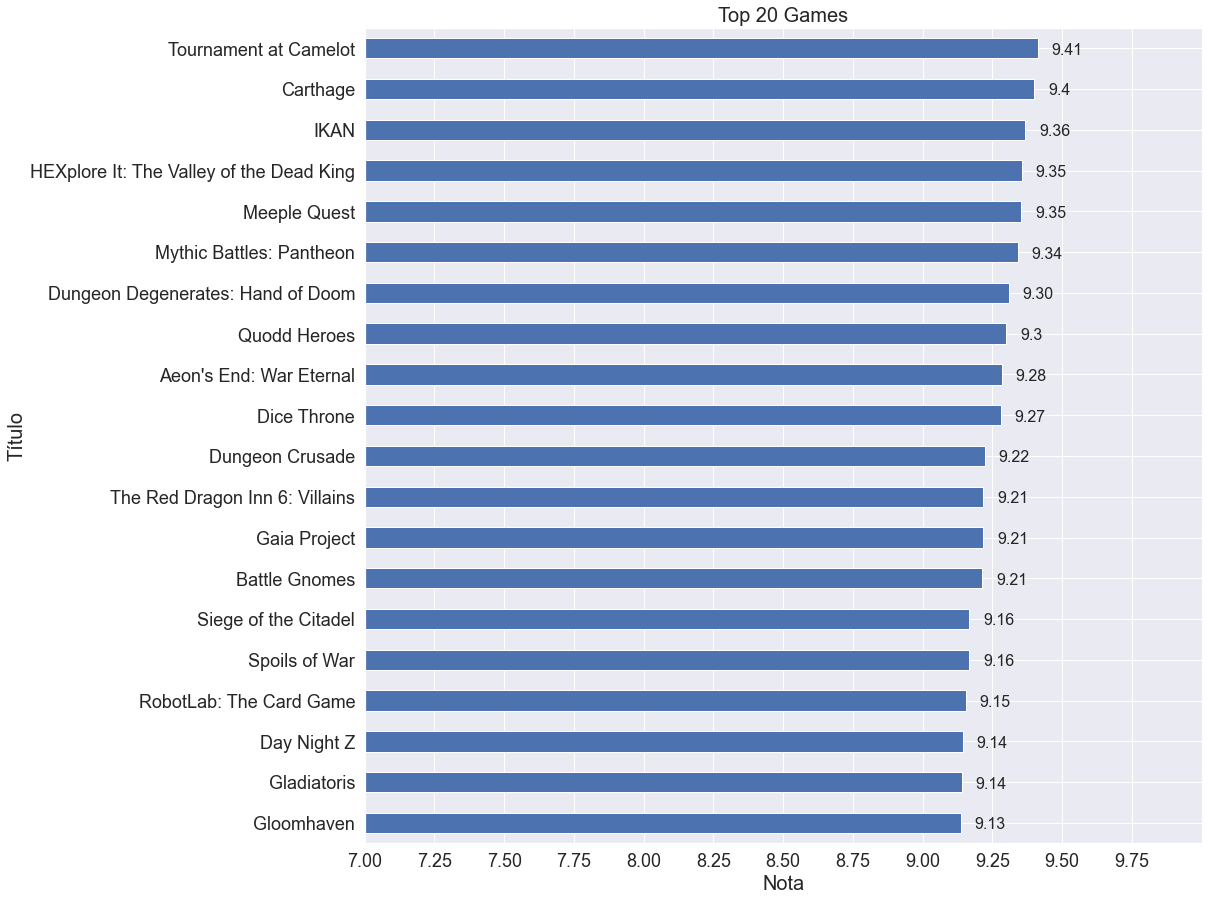

In [460]:
df2 = df.set_index('details.name')
top_games = df2['stats.average'].sort_values(ascending=False)
top_games = top_games[:20]
top_games.sort_values(ascending=True, inplace=True)

plt.figure(figsize=(15,15))
plt.title("Top 20 Games", size=20)
ay = top_games.plot.barh(x='stats.average', y='details.name')
plt.xlabel("Nota", size=20)
plt.ylabel("Título", size=20)
ay.set(xlim=(8, 10))
ay.xaxis.set_ticks(np.arange(7, 10, 0.25))

for tick in ay.xaxis.get_major_ticks():
    tick.label.set_fontsize(18)
for tick in ay.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)
    
for i, v in enumerate(top_games):
    ay.text(v+.05, i-.15, str(v)[:4], fontsize=16)


O gráfico nos mostra que Tournament at Camelot é o jogo mais bem avaliado até o momento. A célula abaixo nos mostra que o jogo era um lancamento recente de 2017 e na época em que os dados foram coletados, apenas 34 usuários tinham avaliado o jogo. Hoje o jogo conta com mais de 900 avaliações e sua nota média é de 7.2 pontos.

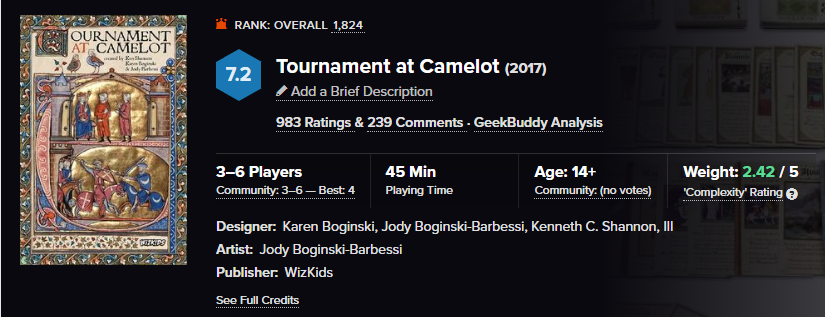

In [495]:
df2 = df.set_index('details.name')
df2.loc[['Tournament at Camelot']][['details.yearpublished', 'stats.usersrated']]

,details.yearpublished,stats.usersrated
details.name,,
Tournament at Camelot,2017.0,34.0


## Quem são os melhores game designers?
Agora que sabemos os jogos melhor avaliados, vamos descobrir quem são os Game Designers queridinhos da comunidade do Board Game Geek. Para isso, vamos pegar a média das avaliações dos jogos de cada autor. 

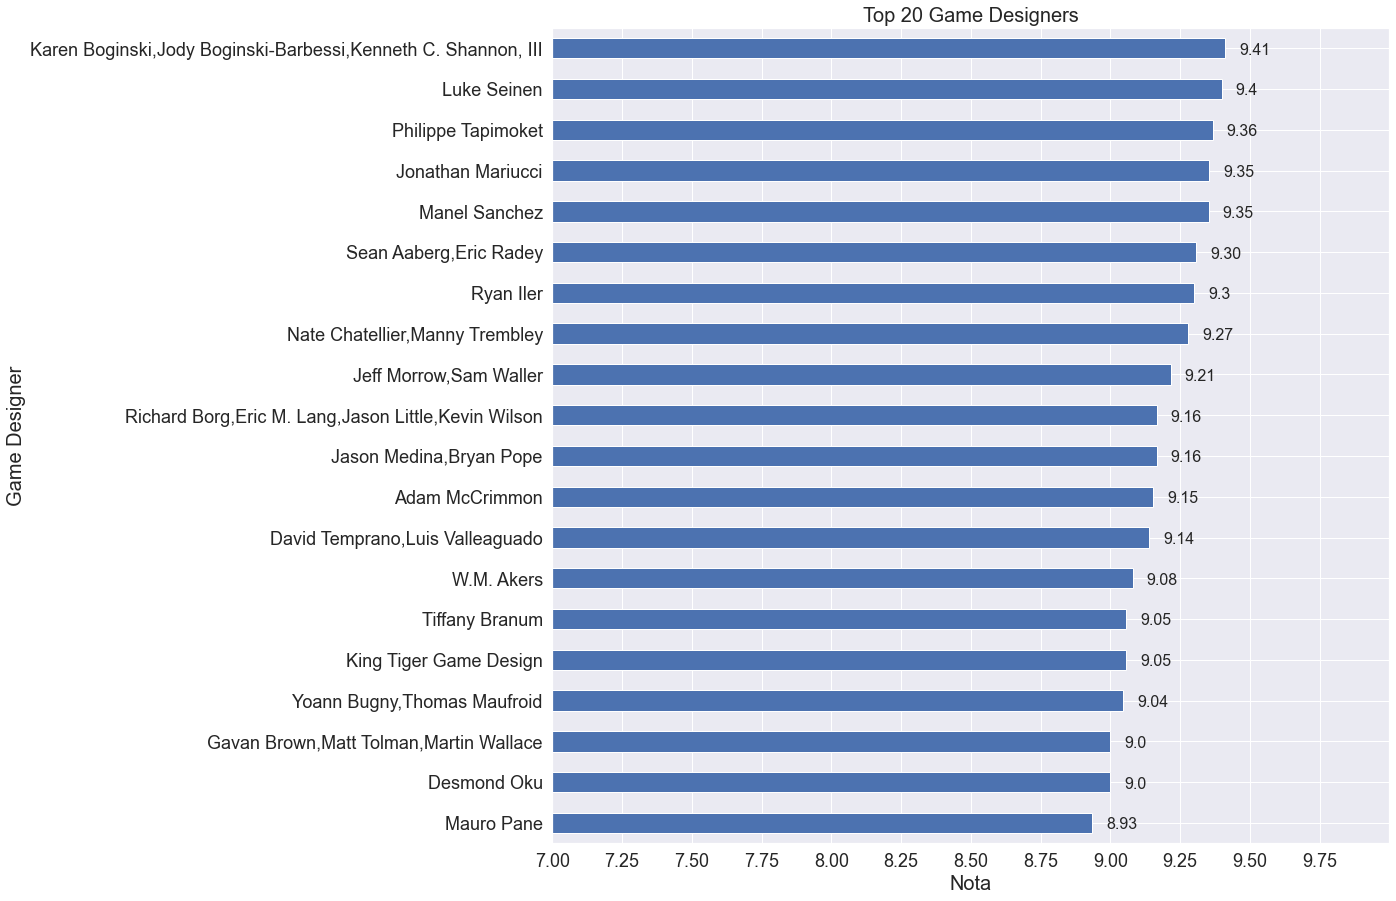

In [461]:
per_game_designer = df.groupby('attributes.boardgamedesigner')['stats.average'].mean()
per_game_designer

top_game_designers = per_game_designer.nlargest(20)
top_game_designers = top_game_designers.sort_values(ascending=True)


plt.figure(figsize=(15,15))
plt.title("Top 20 Game Designers", size=20)
ax = top_game_designers.plot.barh()
plt.xlabel("Nota", size=20)
plt.ylabel("Game Designer", size=20)

ax.set(xlim=(7, 10))
ax.xaxis.set_ticks(np.arange(7, 10, 0.25))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)
    
for i, v in enumerate(top_game_designers):
    ax.text(v +.05, i-.15, str(v)[:4], fontsize=16)

Em primeiro lugar encontramos um grupo de autores, mas vamos reparar na nota média que seus jogos receberam: **9.41**. Se compararmos com a nota do primeiro lugar dentre os jogos vemos que trata-se do mesmo jogo. Vamos confirmar isso na célula a seguir.

In [494]:
df2 = df.set_index('attributes.boardgamedesigner')
df2.loc[['Karen Boginski,Jody Boginski-Barbessi,Kenneth C. Shannon, III']][['details.name']]

,details.name
attributes.boardgamedesigner,
"Karen Boginski,Jody Boginski-Barbessi,Kenneth C. Shannon, III",Tournament at Camelot


## O que define um bom jogo de tabuleiro?
Podemos verificar a correlação entre a nota do jogo, descrita por _stats.average_ com os outros parâmetros, por exemplo o nível de dificuldade **_stats.averageweight_**, a idade mínima **_details.minage_** e a quantidade máxima e mínima de jogadores, respectivamente **_stats.maxplayers_** e **_stats.minplayers_**.

Para essa análise, iremos utilizar apenas os jogos que possuem mais de 100 avaliações, dessa forma, podemos remover jogos que tiveram poucos jogadores, ou seja, que não são tão relevantes para a comunidade em si. 

In [464]:
cmap = sn.choose_diverging_palette(as_cmap=False)

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

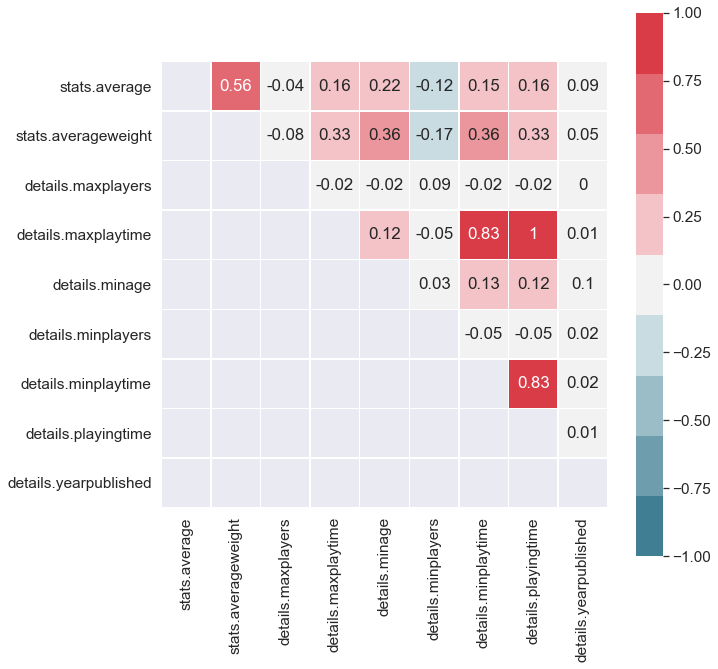

In [46]:
usersrated_100 = df[df['stats.usersrated'] >= 100]
df_corr = ['stats.average', 'stats.averageweight']
for col in usersrated_100:
    if 'details' in col:
        df_corr.append(col)
        
        
sn.set(font_scale=1.4)
df_corr_cols = usersrated_100[df_corr]
df_corr_cols.round(decimals=2)
corrMatrix = df_corr_cols.corr()
mask = np.tril(np.ones_like(corrMatrix, dtype=np.bool))
az = plt.figure(figsize=(10,10))

heatmap = sn.heatmap(corrMatrix.round(decimals=2), mask=mask, linecolor='white', linewidths=.5, 
                     cmap=cmap, vmin=-1, vmax=1, square=True, annot=True)

### Matriz de correlação
Avaliando a matriz de correlação acima, identificamos alguns padrões já esperados, por exemplo, a alta correlação entre o tempo de jogo dos usuários, representado por **_details.playingtime_**, e os tempos mínimos e máximos esperados, respectivamente **_details.minplaytime_** e **_details.maxplaytime_**. É interessante notar também a alta correlação entre a nota do jogo (**_stats.average_**) e sua dificuldade (**_stats.averageweight_**). Isso indica que, de acordo com a comunidade, jogos mais difíceis tendem ter notas mais altas. 

Podemos ver que existe uma certa correlação entre a duração de uma partida e sua dificuldade. De fato, por experiência própria, posso dizer que jogos mais difíceis e complexos, ou seja, com valor de **_stats.averageweight_** alto, tendem a ter partidas bem mais longas que jogos mais simples, os chamados _party games_ ou _fillers_. Também podemos identificar um grau de correlação entre a dificuldade do jogo e a idade mínima, o que já é esperado, crianças muito novas teriam dificuldades com jogos complexos, como _Twilight Imperium_ e _Mage Knight_.



In [76]:
df2 = df.set_index('details.name')
mk_weight = df2.loc['Mage Knight Board Game']['stats.averageweight']
gp_weight = df2.loc['Food Chain Magnate']['stats.averageweight']

print("O grau de dificuldade de Mage Knight é {} e o de Food Chain Magnate é {}, ambos em uma escala de 0 a 5".format(mk_weight.round(decimals=2), gp_weight.round(decimals=2)))

O grau de dificuldade de Mage Knight é 4.21 e o de Food Chain Magnate é 4.18, ambos em uma escala de 0 a 5


### A dificuldade é tão importante assim?
De acordo com a matriz de correlação acima, jogos mais difíceis são os favoritos dos usuários do BGG, mas como podemos ver abaixo, eles não são a maioria! Na verdade, a maior parte dos jogos está no nível de dificuldade considerado "Simples", entre 2 e 3. 

Text(0, 0.5, 'Número de Jogos')

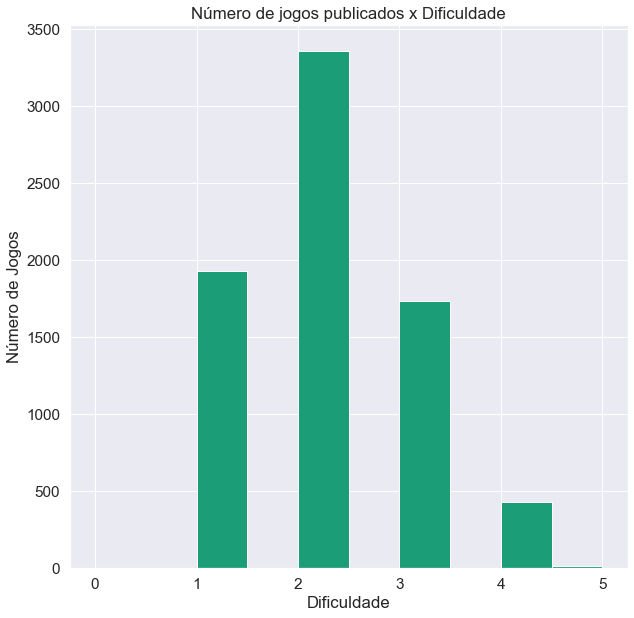

In [457]:
numberxweight = usersrated_100['stats.averageweight'].round()
numberxweight.plot(kind="hist", figsize=(10,10), colormap='Dark2')
plt.title("Número de jogos publicados x Dificuldade")
plt.xlabel("Dificuldade") 
plt.ylabel("Número de Jogos")

### Avaliando a relação entre dificuldade e nota
Vamos fazer uma análise mais profunda da relação entre dificuldade e a nota do jogo.

Text(26.89399999999999, 0.5, 'Dificuldade')

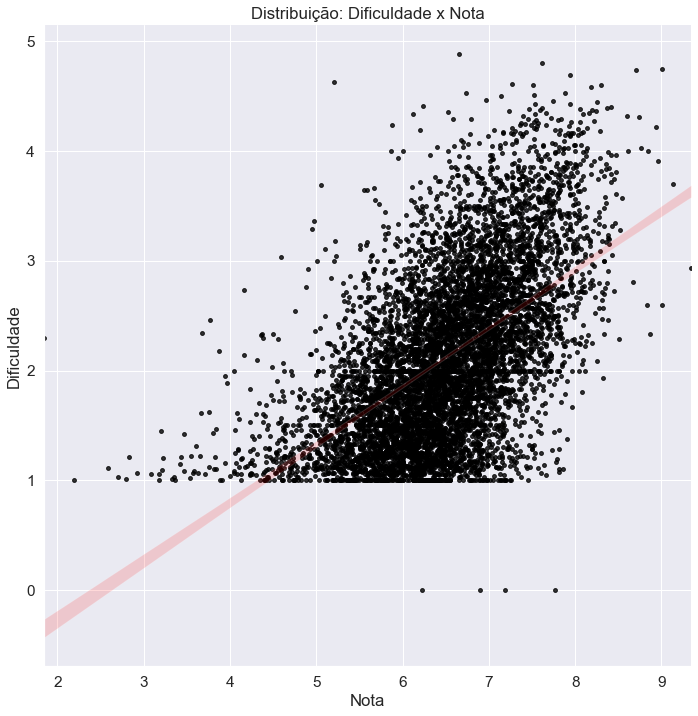

In [215]:
averagexweight = usersrated_100[['details.name', 'stats.averageweight', 'stats.average']]
averagexweight = averagexweight.sort_values('stats.averageweight', ascending=False)

# sn.set(font_scale=1.4)
sn.lmplot('stats.average', 'stats.averageweight', averagexweight, 
               scatter_kws={"s": 15, 'color':'black'}, line_kws={'color': 'red'}, height=10)
# \n
plt.title('Distribuição: Dificuldade x Nota')
plt.xlabel('Nota')
plt.ylabel('Dificuldade')
# good_rate

Como podemos ver no gráfico acima, de fato, existe uma tendência dos jogos mais difíceis obterem notas mais altas. Entretanto, a maior parte dos jogos encontra-se na faixa de dificuldade considerada mais simples e mesmo estes receberam boas avaliações.

In [463]:
averagexweight.describe()

,stats.averageweight,stats.average
count,7465.000000,7465.000000
mean,2.113802,6.477613
std,0.777561,0.821200
min,0.000000,1.845980
25%,1.466700,5.967730
50%,2.000000,6.492110
75%,2.625000,7.020280
max,4.881400,9.340440


### Avaliando a relação entre número de jogadores e nota

Text(0, 0.5, 'Número Mínimo de Jogadores')

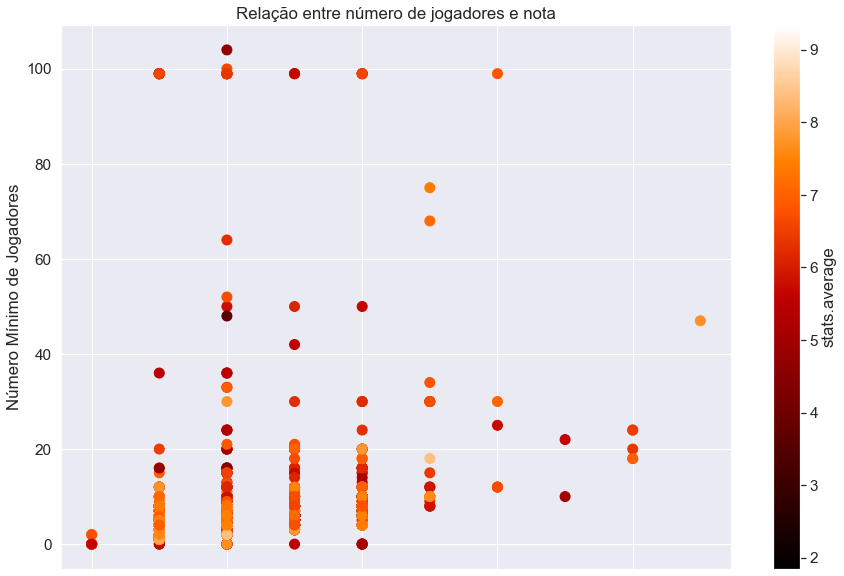

In [462]:
averagexplayers = usersrated_100[['details.name', 'details.minplayers', 'details.maxplayers', 'stats.average']]
averagexplayers.set_index('details.maxplayers')
averagexplayers = averagexplayers.drop(23008) # Removendo outliers
averagexplayers = averagexplayers.drop(65996) # Removendo outliers


fig = averagexplayers.plot(x='details.minplayers', y='details.maxplayers',
                     c='stats.average', colormap='gist_heat',
                     figsize=(15, 10), kind='scatter',
                     title='Relação entre número de jogadores e nota',
                     s=100)
plt.xlabel('Número Máximo de Jogadores')
plt.ylabel('Número Mínimo de Jogadores')